In [721]:
import pandas as pd
import numpy as np
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from lightkurve import search_targetpixelfile
import os
import lightkurve as lk
from matplotlib import rc
import scipy
import corner
import random
import exoplanet as xo
import pymc as pm
import celerite2.jax
from celerite2.jax import terms
import jax.numpy as jnp
from functools import partial
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from celerite2.pymc import GaussianProcess, terms as pm_terms
from astroquery.simbad import Simbad

In [2]:
%matplotlib inline

In [58]:
def gp_log_like(r, K):
    """
    Pulled from Dan's notebook, updated with Cholesky decomposition
    https://github.com/dfm/gp/blob/main/solutions.ipynb
    """
    # Slow version, factor ~2x slower.
    #return -0.5 * (np.dot(r, np.linalg.solve(K, r)) + np.linalg.slogdet(K)[1])

    # Cholesky decomposition, faster
    # For more info, check out: https://math.stackexchange.com/questions/3158303/using-cholesky-decomposition-to-compute-covariance-matrix-determinant
    try:
        cho_decomp = scipy.linalg.cho_factor(K)
        log_det_cov = 2*np.sum(np.log(np.diag(cho_decomp[0])))
        return -0.5 * (np.dot(r, scipy.linalg.cho_solve(cho_decomp, r)) + log_det_cov + (len(r)*np.log(2.*np.pi)))
    except np.linalg.LinAlgError:
        return -np.inf

def quasi_per(t1, t2, *, A, l, gamma, P):
    return A*np.exp(-gamma**2*np.sin(np.pi*(t1 - t2)/P)**2 - (t1 - t2)**2/(2*l**2))

In [59]:
def one_gp_log_prob(params, priors, t, y, y_err):

    for i in range(len(params)):
        if params[i] < priors[i][0] or params[i] > priors[i][1]:
            return -np.inf

    jitter = np.exp(params[0])
    kernel_params = params[1:]

    # quasi_per
    A = kernel_params[0]
    l = kernel_params[1]
    gamma = kernel_params[2]
    P = kernel_params[3]

    # Compute the covariance matrix
    K = quasi_per(t[:, None], t[None, :], A=A, l=l, gamma=gamma, P=P)

    K[np.diag_indices_from(K)] += y_err**2 + jitter

    # Compute the negative log likelihood
    return gp_log_like(y, K)

def one_gp_neg_log_prob(params, priors, t, y, y_err):
    return -one_gp_log_prob(params, priors, t, y, y_err)

In [60]:
def minimize_one_gp_kernel(t, bounds, y, err, p0):

    result = scipy.optimize.minimize(one_gp_neg_log_prob, p0, args=(bounds, t, y, err), bounds=bounds)

    return result

In [61]:
def sample_one_gp(t, y, y_err, pos, bounds, bknd_fn,
                  ndim=5, n_run=5000, nwalkers=50, reset=True):
    """
    Use emcee to sample a 1D GP.
    """

    pos_fixed = []

    for b, p in zip(bounds, pos):
        if p <= b[0]:
            pos_fixed.append(p + 0.01)
        elif p >= b[-1]:
            pos_fixed.append(p - 0.01)
        else:
            pos_fixed.append(p)

    pos = np.array(pos_fixed) + 1e-3*np.random.randn(nwalkers, ndim)

    backend = emcee.backends.HDFBackend(bknd_fn)
    if reset:
        backend.reset(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, one_gp_log_prob, args=(bounds, t, y, y_err), backend=backend)

    if reset:
        sampler.run_mcmc(pos, n_run, progress=True);
    else:
        sampler.run_mcmc(None, n_run, progress=True);

def one_cov(params, t1, t2, y_err):
    """
    Covariance matrix for one-dimensional GP case.
    """
    jitter = np.exp(params[0])
    kernel_params = params[1:]

    # quasi_per
    A = kernel_params[0]
    l = kernel_params[1]
    gamma = kernel_params[2]
    P = kernel_params[3]

    # Compute the covariance matrix for the first GP
    K = quasi_per(t1, t2, A=A, l=l, gamma=gamma, P=P)

    if y_err is not None:
        K[np.diag_indices_from(K)] += jitter + y_err**2

    return K

In [62]:
def predict_one(p, t, y, y_err, t_test=None, y_predict=None, y_err_predict=None, n_test=1000):
    """
    Compute the predicted mean GP model.
    """

    cov_train = one_cov(p, t[:, None], t[None, :], y_err)

    factor = (scipy.linalg.cholesky(cov_train, overwrite_a=False, lower=False), False)
    alpha  = scipy.linalg.cho_solve(factor, y, overwrite_b=False)

    if t_test is None:
        t_test = np.linspace(min(t), max(t), n_test)

    cov_test_only = one_cov(p, t_test[:, None], t_test[None, :], np.zeros_like(t_test))
    cov_test = one_cov(p, t_test[:, None], t[None, :], None)

    mu = np.dot(cov_test, alpha)

    if y_predict is not None:
        cov_predict = cov_test_only - np.dot(cov_test, np.linalg.solve(cov_train, cov_test.T))
        var = cov_predict[np.diag_indices_from(cov_predict)]
        cov_predict[np.diag_indices_from(cov_predict)] += y_err_predict**2
        logL = one_gp_log_prob(y_predict - mu, cov_predict)

        return mu, var, t_test, logL

    else:
        var = cov_test_only[np.diag_indices_from(cov_test_only)]
        inv_cov_test = np.linalg.solve(cov_train, cov_test.T)
        var -= np.sum(cov_test.T * inv_cov_test, axis = 0)

        return mu, var, t_test

In [63]:
qp_priors = np.array([(np.log(1e-12), np.log(1e1)), # jitter
             (1e-3, 5.0), # A
             (1e-3, 100.0), # l
             (1e-3, 100.0), # Gamma
             (0.1, 30.0)]) #P] #10 for most things

In [391]:
def gp_model(t, flux, ferr, peak_period):
    with pm.Model() as model:

        log_jitter = pm.Normal("log_jitter", mu=2*np.log(np.min(ferr)), sigma=5.0)
        jitter = tt.exp(log_jitter)

        A = pm.Uniform("A", 1e-3, 5.0)
        l = pm.Uniform("l", 1e-3, 100)
        gamma = pm.Uniform("gamma", 1e-3, 100)
        log_period = pm.Uniform("log_period", np.log(peak_period/100), np.log(peak_period*2), testval=np.log(peak_period))
        period = pm.Deterministic("period", tt.exp(log_period))

        K = A * tt.exp(-tt.square(gamma) * tt.square(tt.sin(np.pi * (t[:,None] - t[None,:]) / period)) - 
                       tt.square(t[:,None] - t[None,:]) / (2 * tt.square(l)))

        K = tt.set_subtensor(
            K[tt.arange(K.shape[0]), tt.arange(K.shape[0])],
            K[tt.arange(K.shape[0]), tt.arange(K.shape[0])] + ferr**2 + jitter
        )
        
        cho_decomp = tt.slinalg.cholesky(K) 
        log_det_cov = 2 * tt.sum(tt.log(tt.diag(cho_decomp)))

        flux_solve = tt.slinalg.solve_upper_triangular(cho_decomp.T, tt.slinalg.solve_lower_triangular(cho_decomp, flux))
        quad_term = tt.dot(flux, flux_solve)

        loglike = -0.5 * (quad_term + log_det_cov + (flux.shape[0] * tt.log(2. * np.pi)))
        pm.Potential('loglike', loglike)
        
    return model

# Modeling TESS stars

In [278]:
kic_ids_santos = ['757099', '757450','891916','892195','892713','893209','893286',
    '893383','893505','893507','893559','893676','1025986','1026838','1027536'
]

In [279]:
rotation_periods_santos = [0.38,19.11,5.45,21.78,5.78,4.58,24.54,
    21.19,10.81,10.98,14.69,24.37,9.68,15.56,16.35
]

In [280]:
rotation_uncertainties = [0.02,1.50,0.42,2.90,0.76,0.44,2.23,2.58,0.81,
    0.86,1.06,2.73,0.73,1.85,4.43
]

In [281]:
def kic_to_tic(kic_ids):
    simbad = Simbad()
    simbad.add_votable_fields('ids')
    tic_ids = []
    missing_kics = []
    
    for n, kic in enumerate(kic_ids):
        result = simbad.query_object("KIC"+kic)
        ids = result['IDS'][0].split('|')
        found_tic = False
        for id in ids:
            if 'TIC' in id:
                tic_ids.append(id)
                found_tic = True
                break
        
        if not found_tic:
            missing_kics.append(n)
    
    return tic_ids, missing_kics

In [282]:
tic_santos, missing_indices = kic_to_tic(kic_ids_santos)

In [283]:
kic_ids_santos = np.array(kic_ids_santos)
kic_ids_santos = np.delete(kic_ids_santos,missing_indices)
rotation_periods_santos = np.array(rotation_periods_santos)
rotation_periods_santos = np.delete(rotation_periods_santos,missing_indices)
rotation_uncertainties = np.array(rotation_uncertainties)
rotation_uncertainties = np.delete(rotation_uncertainties,missing_indices)

In [284]:
kic_ids_santos.shape

(11,)

In [531]:
tic_santos

['TIC 122785244',
 'TIC 122785299',
 'TIC 122679340',
 'TIC 122785143',
 'TIC 137099457',
 'TIC 137099560',
 'TIC 137099563',
 'TIC 137099403',
 'TIC 137146193',
 'TIC 122784720',
 'TIC 137146361']

In [286]:
missing_indices

[3, 5, 8, 13]

In [641]:
star_name = tic_santos[0]
santos = rotation_periods_santos[0]
santos_sigma = rotation_uncertainties[0]
lc = lk.search_lightcurve(star_name).download().remove_nans().remove_outliers()
# lcf = lk.search_lightcurve(
#     star_name, author='Kepler'
# ).download_all(flux_column="pdcsap_flux")
# lc = lcf.stitch()
# lc = lc[:10000]
# binned_lc = lc.bin(time_bin_size=30./1440.) # bin in chunks of 30 minutes
# binned_lc = binned_lc.remove_nans()#.remove_outliers()

/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 11 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [642]:
lc

time,flux,flux_err,cadenceno,sap_flux,kspsap_flux,kspsap_flux_err,quality,orbitid,sap_x,sap_y,sap_bkg,sap_bkg_err,kspsap_flux_sml,kspsap_flux_lag
,,,,,,,,,pix,pix,,,,
Time,float32,float32,int32,float32,float32,float32,int32,int32,float32,float32,float32,float32,float32,float32
1683.3635433562742,0.988146185874939,0.01409622747451067,21883,0.9881462,0.9943331,0.0140962275,4096,35,515.3858032226562,580.392578125,2443.71,7222.13,0.9928102,0.99346703
1683.384376994658,0.9882292151451111,0.01409622747451067,21884,0.9882292,1.0029258,0.0140962275,4096,35,515.3870239257812,580.3958740234375,2371.72,7296.81,1.0009148,1.0035664
1683.405210633378,0.9789875149726868,0.01409622747451067,21885,0.9789875,1.0006264,0.0140962275,4096,35,515.3883056640625,580.396484375,2337.53,7394.38,1.0022098,1.0010889
1683.426044272402,0.9755429029464722,0.01409622747451067,21886,0.9755429,1.002894,0.0140962275,4096,35,515.3878173828125,580.398681640625,2526.82,6961.55,1.0040504,1.0042621
1683.4468779117142,0.9665941596031189,0.01409622747451067,21887,0.96659416,0.9982571,0.0140962275,4096,35,515.3878173828125,580.3972778320312,2479.59,7010.89,1.0011795,0.9983632
1683.4677115512661,0.967159628868103,0.01409622747451067,21888,0.9671596,1.002325,0.0140962275,4096,35,515.3883666992188,580.3978881835938,2347.02,7056.55,1.0034906,1.0031742
1683.4885451910468,0.9622930288314819,0.01409622747451067,21889,0.962293,0.99976724,0.0140962275,4096,35,515.3885498046875,580.3986206054688,2581.6,7146.33,1.0026695,0.999079
1683.5093788310305,0.9629694223403931,0.01409622747451067,21890,0.9629694,1.0020769,0.0140962275,4096,35,515.38720703125,580.400146484375,2481.33,6602.29,1.0041977,1.0027012


In [682]:
t_  = lc.time.value
flux_ = np.ascontiguousarray(lc.flux.value)
ferr_  = np.ascontiguousarray(lc.flux_err.value)

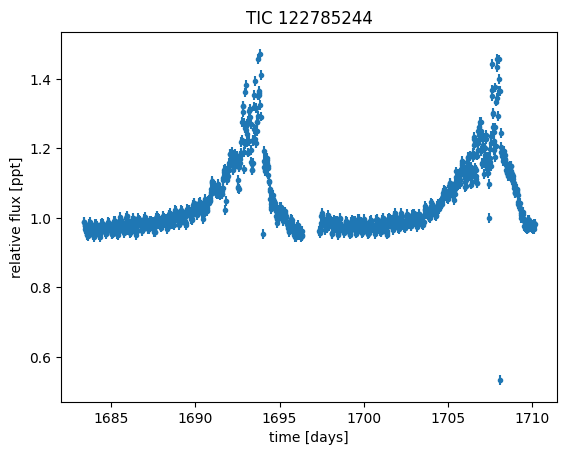

In [683]:
plt.errorbar(t_, flux_, yerr=ferr_, fmt='.')
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title(f"{star_name}")
# plt.xlim(150,205)

In [684]:
# mask = ~((1690 <= t_) & (t_ <= 1695) | (1704 <= t_) & (t_ <= 1710))
mask = ~(1690 <= t_)
t_ = t_[mask]
flux_ = flux_[mask]
ferr_ = ferr_[mask]

In [685]:
np.sum(np.isnan(flux_))

0

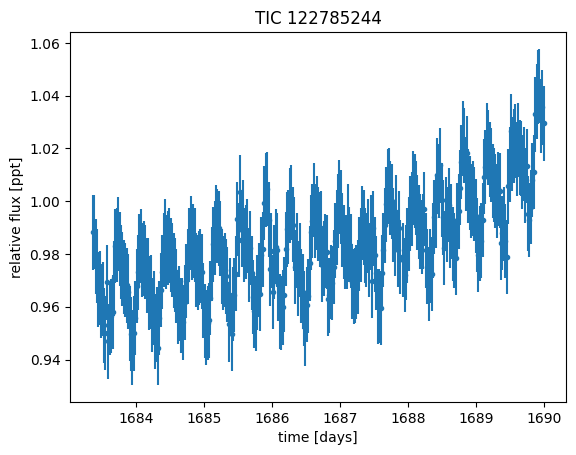

In [686]:
plt.errorbar(t_, flux_, yerr=ferr_, fmt='.')
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title(f"{star_name}")
# plt.xlim(1685,1687)

(0.0, 10.0)

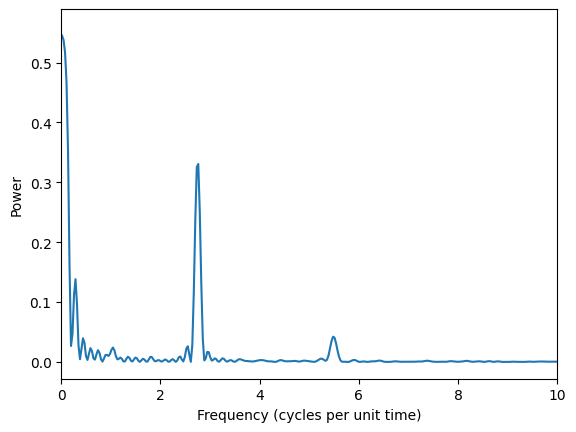

In [702]:
import nifty_ls
from astropy.timeseries import LombScargle

frequency, power = LombScargle(t_, flux_).autopower()
plt.plot(frequency, power)
peak = frequency[np.where(power==np.max(power))[0][0]]
plt.axvline(peak, color='black')
plt.xlabel('Frequency (cycles per unit time)')
plt.ylabel('Power')
plt.xlim(0,10)

In [688]:
peak_period=1/peak

In [689]:
peak_period

0.010411907666061006

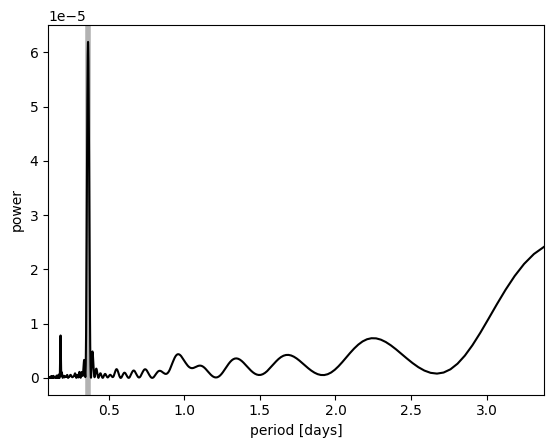

In [705]:
results = xo.estimators.lomb_scargle_estimator(
    t_, flux_, max_peaks=1, min_period=0.1, max_period=santos+3, samples_per_peak=25
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
# plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

In [691]:
santos

0.38

In [692]:
peak['period']

0.3637935124354824

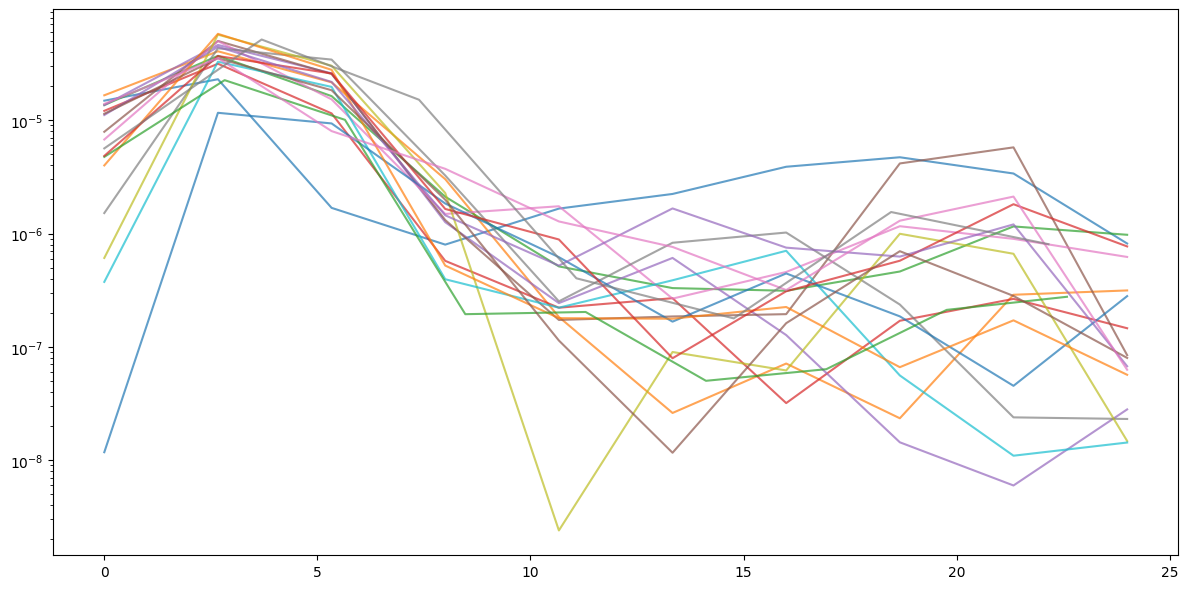

In [693]:
from matplotlib.gridspec import GridSpec
from scipy import signal

time_days = t_ - t_[0]
segment_days = peak['period']

segment_indices = []
current_idx = 0

while current_idx < len(t_):
    segment_end = np.searchsorted(time_days[current_idx:], time_days[current_idx] + segment_days)
    if segment_end == 0:
        break
    segment_indices.append((current_idx, current_idx + segment_end))
    current_idx += segment_end

sampling_freq = 1.0 / np.median(np.diff(t_))

n_segments = len(segment_indices)
n_cols = 3
n_rows = (n_segments + n_cols - 1) // n_cols

# fig = plt.figure(figsize=(15, 4*n_rows))
gs = GridSpec(n_rows, n_cols)

spectra = []

for i, (start_idx, end_idx) in enumerate(segment_indices):
    segment_time = t_[start_idx:end_idx]
    segment_flux = flux_[start_idx:end_idx]
    
    nperseg = min(len(segment_flux), 256)
    freqs, psd = signal.welch(segment_flux, fs=sampling_freq, window='hann', nperseg=nperseg)
    spectra.append((freqs, psd))
    
    row = i // n_cols
    col = i % n_cols
    ax = fig.add_subplot(gs[row, col])
    
    # ax.semilogy(freqs, psd)
    start_time = time_days[start_idx]
    end_time = time_days[end_idx-1]
    # ax.set_title(f'Days {start_time:.1f}-{end_time:.1f}')

# plt.tight_layout()
# plt.show()

fig2, ax = plt.subplots(figsize=(12, 6))

for i, (freqs, psd) in enumerate(spectra):
    start_time = i * segment_days
    end_time = start_time + segment_days
    ax.semilogy(freqs, psd, alpha=0.7, label=f'Days {start_time:.1f}-{end_time:.1f}')


plt.tight_layout()
plt.show()

In [720]:
np.log(36)

3.58351893845611

In [ ]:
def gp_model(t, flux, ferr, peak_period):
    mean_flux = np.mean(flux)
    std_flux = np.std(flux)
    dt_median = np.median(np.diff(t))
    T = t[-1] - t[0]

    with pm.Model() as model:
        mean = pm.Normal("mean", mu=mean_flux, sigma=std_flux)

        sigma_rot1 = pm.Exponential("sigma_rot1", lam=1/std_flux)
        if peak_period<1:
            log_period1 = pm.Uniform("log_period1", np.log(max(0.1,peak_period-2)), np.log(peak_period+1))
        else:
            log_period1 = pm.Normal("log_period1", mu=np.log(peak_period), sigma=0.01)
        period1 = pm.Deterministic("period1", pm.math.exp(log_period1))
        log_tau1 = pm.Uniform('log_tau1', np.log(period1), np.log(100*period1))
        tau1 = pm.Deterministic('tau1', pm.math.exp(log_tau1))

        sigma_rot2 = pm.Exponential("sigma_rot2", lam=1/std_flux)
        period2 = pm.Deterministic("period2", period1 / 2.0)
        log_tau2 = pm.Uniform('log_tau2', np.log(period2), np.log(100*period2))
        tau2 = pm.Deterministic('tau2', pm.math.exp(log_tau2))

        kernel1 = pm_terms.SHOTerm(sigma=sigma_rot1, tau=tau1, rho=period1)
        kernel2 = pm_terms.SHOTerm(sigma=sigma_rot2, tau=tau2, rho=period2)
        kernel = kernel1 + kernel2  

        gp = GaussianProcess(
            kernel,
            t=t,
            diag=ferr**2,
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood
        gp.marginal("gp", observed=flux)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(flux))

    return model

In [714]:
model = gp_model(t_, flux_, ferr_, peak['period'])

/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


In [715]:
with model:
    map_soln = pm.find_MAP()

/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

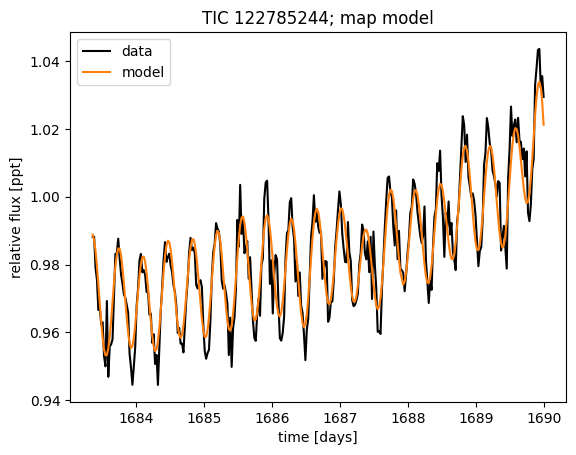

In [716]:
plt.plot(t_, flux_, "k", label="data")
plt.plot(t_, map_soln["pred"], color="C1", label="model")
# plt.xlim(t.min(), t[15000])
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title(f"{star_name}; map model")

In [717]:
map_soln['period1']

array(0.7287973)

In [718]:
peak['period']

0.3637935124354824

In [719]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=4,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
    )

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_33936/2393868277.py:2: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:763: RuntimeWarning: inv

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mean': array(0.06630683), 'sigma_rot1_log__': array(-4.1206666), 'log_period1_interval__': array(0.8385737), 'log_tau1_interval__': array(-3.74344601), 'sigma_rot2_log__': array(-4.16064245), 'log_tau2_interval__': array(nan)}

Logp initial evaluation results:
{'mean': -1153.0, 'sigma_rot1': -1.01, 'log_period1': -1.56, 'log_tau1': -3.79, 'sigma_rot2': -1.02, 'log_tau2': nan, 'gp': -inf}
You can call `model.debug()` for more details.

In [665]:
vars_names = ["log_period1",
        "tau1",
        "sigma_rot1",
        # "log_jitter",
        "mean",
        ]

/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or

array([[<Axes: title={'center': 'log_period1'}>,
        <Axes: title={'center': 'log_period1'}>],
       [<Axes: title={'center': 'tau1'}>,
        <Axes: title={'center': 'tau1'}>],
       [<Axes: title={'center': 'sigma_rot1'}>,
        <Axes: title={'center': 'sigma_rot1'}>],
       [<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'mean'}>]], dtype=object)

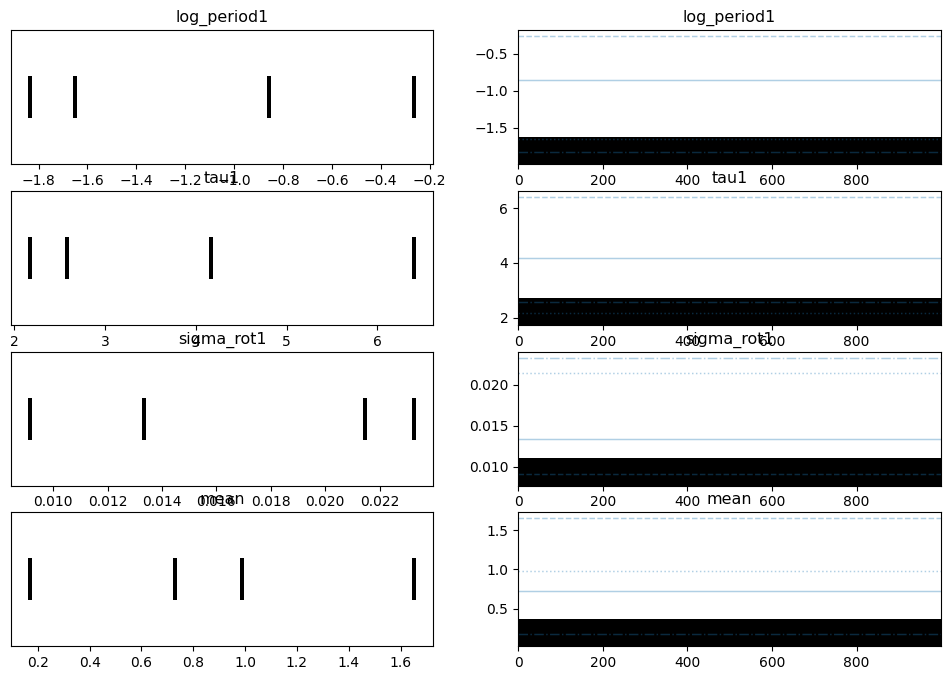

In [666]:
import arviz as az
az.plot_trace(trace, var_names=vars_names)

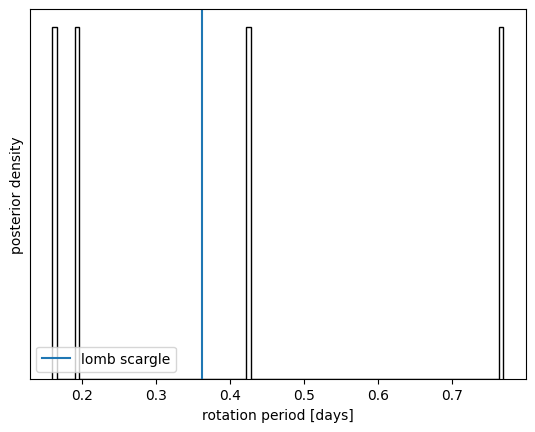

In [667]:
period_samples = np.asarray(trace.posterior["period1"]).flatten()
plt.hist(period_samples, 100, histtype="step", color="k", density=True)
plt.axvline(peak['period'], label='lomb scargle')
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.legend()

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_33936/3993405560.py:57: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  model_legend = ax[0].legend([model_plot1], ["GP Model"], fontsize=22, markerscale=3.0, loc="center",


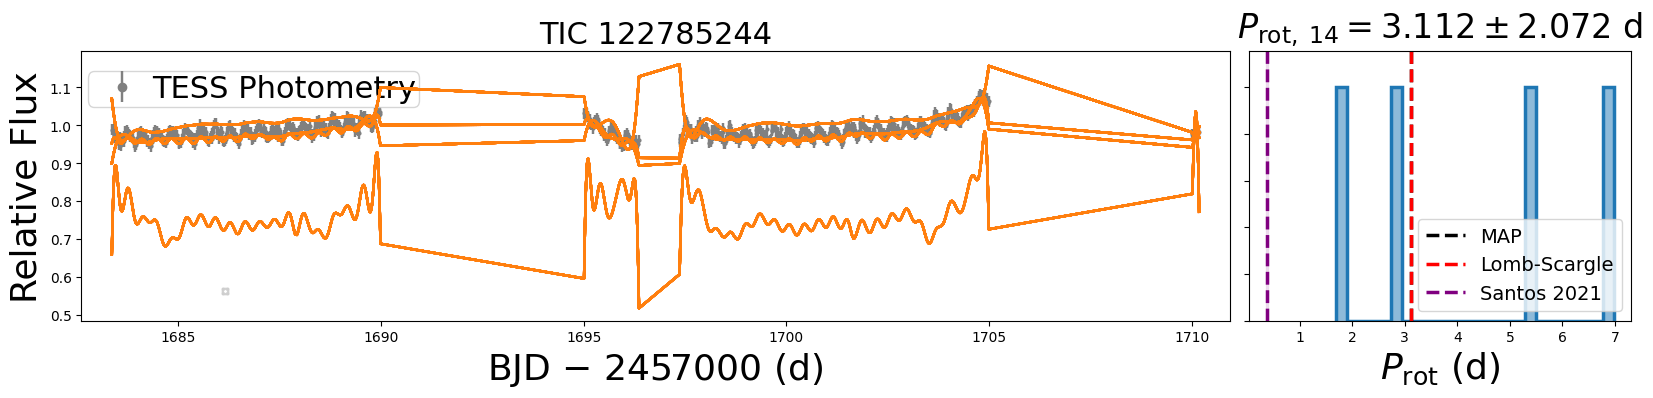

In [590]:
period_samples = np.asarray(trace.posterior["period1"]).flatten()
gridspec = {'hspace':0.35, 'wspace':0.025, 'width_ratios':[3.0, 1.0]}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 3.5), gridspec_kw=gridspec)

data1 = ax[0].errorbar(x=t_, y=flux_, yerr=ferr_, ls='',
            markersize=2., elinewidth=1.75, barsabove=False, marker='o',
            markerfacecolor='grey', ecolor='grey', markeredgecolor='grey',
            rasterized=True, zorder=1)
for i in range(100):
    model_plot1 = ax[0].plot(t_, trace.posterior['pred'][random.randint(0,3)][random.randint(0,999)], color="C1", label="QP GP Model", lw=1.75, zorder=10)

ax[1].hist(period_samples, bins=25, histtype="stepfilled", color="C0", alpha=0.5)
ax[1].hist(period_samples, bins=25, histtype="step", color="C0", lw=2.5)

prot1_ax_lim = ax[1].get_ylim()
ax[1].set_ylim([prot1_ax_lim[0], prot1_ax_lim[-1]*1.1])

ax[1].axvline(map_soln['period1'], color='black', ls='--', lw=2.5, label='MAP')
ax[1].axvline(peak['period'], color='red', ls='--', lw=2.5, label='Lomb-Scargle')
ax[1].axvline(santos, color='purple', ls='--', lw=2.5, label='Santos 2021')
ax[1].axvspan(santos - santos_sigma, santos + santos_sigma, 
              color='purple', alpha=0.1, zorder=1)

# x_gaussian = np.linspace(santos - 2*santos_sigma, santos + 2*santos_sigma, 100)
# pdf_values = scipy.stats.norm.pdf(x_gaussian,santos,santos_sigma)
# scaling_factor = prot1_ax_lim[-1] * 1.0  # Adjust this factor to change relative height
# pdf_values_scaled = pdf_values * scaling_factor / pdf_values.max()
# ax[1].plot(x_gaussian, pdf_values_scaled, color='purple', ls='-', lw=2.5, label='Santos 2021')
# ax[1].axvline(santos, color='purple', ls='--', lw=2.5, label='Santos 2021')


ax[1].set_title(r"$P_\mathrm{{rot, \; {2}}} = {0:.3f} \pm {1:.3f}$ d".format(map_soln['period1'], np.std(period_samples, ddof=1), lc.SECTOR), color="black", fontsize=24, pad=10)

ax[1].tick_params(labelleft=False)

ax[0].set_xlim(t_.min()-0.75, t_.max()+0.75)

ax[0].set_title(f"{star_name}", fontsize=22)

current_ylim = ax[0].get_ylim()

ax[0].set_ylim([0.998*current_ylim[0], 1.002*current_ylim[-1]])

ax[0].set_xlabel("BJD $-$ 2457000 (d)", fontsize=26)
ax[0].set_ylabel("Relative Flux", fontsize=26)

ax[1].set_xlabel(r"$P_\mathrm{rot}$ (d)", fontsize=26)

ax[0].legend(fontsize=18, markerscale=3.0, handletextpad=0.4)
ax[1].legend(fontsize=14)

data_legend = ax[0].legend([data1], ["TESS Photometry"], fontsize=22,
                            markerscale=3.0, loc="center", handletextpad=0.005, labelspacing=0.1,
                            borderaxespad=0.1, borderpad=0.1,
                            bbox_transform=ax[0].transAxes, bbox_to_anchor=(0.15, 0.86))

model_legend = ax[0].legend([model_plot1], ["GP Model"], fontsize=22, markerscale=3.0, loc="center",
                            handletextpad=0.5, labelspacing=0.2,
                            borderaxespad=0.1, borderpad=0.1,
                            bbox_transform=ax[0].transAxes, bbox_to_anchor=(0.125, 0.11))

ax[0].add_artist(data_legend)
ax[0].add_artist(model_legend)

plt.savefig(f'{star_name}.pdf', dpi=300)

/Users/sabina/miniconda3/envs/starry-env/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 128 is greater than input length  = 29, using nperseg = 29
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/sabina/miniconda3/envs/starry-env/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 128 is greater than input length  = 26, using nperseg = 26
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/sabina/miniconda3/envs/starry-env/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 128 is greater than input length  = 28, using nperseg = 28
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/sabina/miniconda3/envs/starry-env/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 128 is greater than input length  = 10, using nperseg = 10
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/sabina/mi

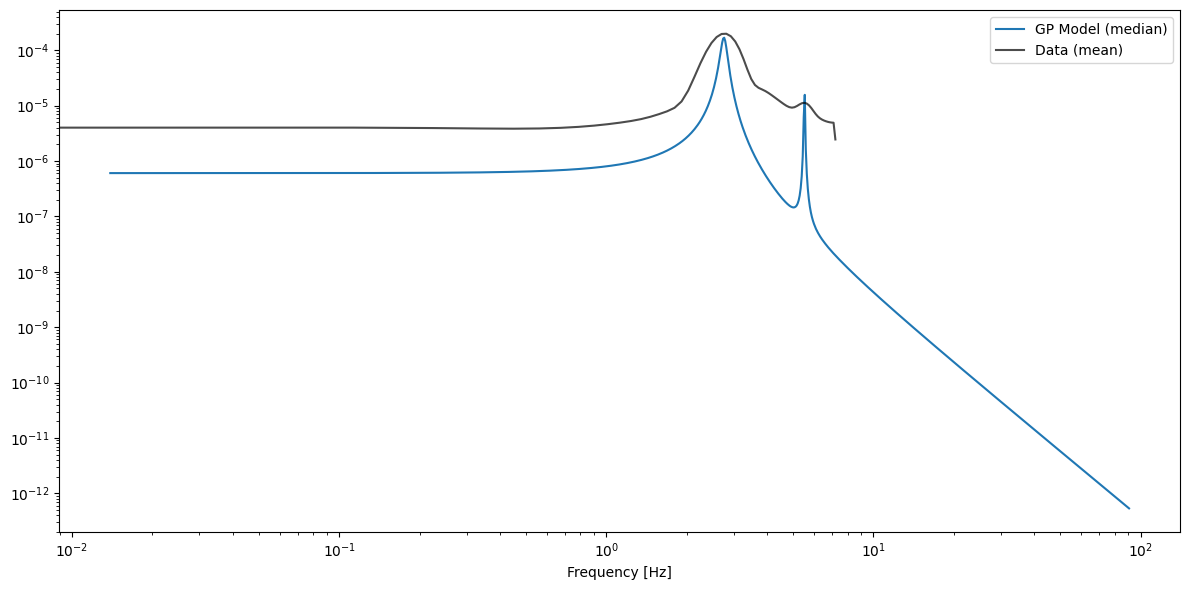

In [355]:
def get_model_power_spectrum(t, trace, samples=1000):
    freq = np.logspace(np.log10(2*np.pi/t.max()), np.log10(2*np.pi/np.min(np.diff(t))), 1000)
    power_spectra = np.zeros((samples, len(freq)))
    
    for i in range(samples):
        idx = np.random.randint(len(trace.posterior["sigma_rot1"].values.flatten()))
        
        kernel1 = terms.SHOTerm(
            sigma=float(trace.posterior["sigma_rot1"].values.flatten()[idx]),
            tau=float(trace.posterior["tau1"].values.flatten()[idx]),
            rho=float(trace.posterior["period1"].values.flatten()[idx])
        )
        kernel2 = terms.SHOTerm(
            sigma=float(trace.posterior["sigma_rot2"].values.flatten()[idx]),
            tau=float(trace.posterior["tau2"].values.flatten()[idx]),
            rho=float(trace.posterior["period2"].values.flatten()[idx])
        )
        kernel = kernel1 + kernel2
        power_spectra[i] = kernel.get_psd(2*np.pi*freq)
    
    return freq, np.percentile(power_spectra, [16, 50, 84], axis=0)

time_days = t_ - t_[0]
segment_indices = []
current_idx = 0
segment_days = 2

min_segment_length = len(t_)
while current_idx < len(t_):
    segment_end = np.searchsorted(time_days[current_idx:], time_days[current_idx] + segment_days)
    if segment_end == 0:
        break
    segment_indices.append((current_idx, current_idx + segment_end))
    current_idx += segment_end

sampling_freq = 1.0 / np.median(np.diff(t_))
nperseg = min(min_segment_length, 128)  # reduced from 256 to ensure consistency
nfft = nperseg

# Pre-calculate frequency array
freqs = np.fft.rfftfreq(nfft, d=1/sampling_freq)

# Pre-allocate array for all PSDs
all_psds = np.zeros((len(segment_indices), len(freqs)))

# Calculate power spectrum for each segment
for i, (start_idx, end_idx) in enumerate(segment_indices):
    segment_flux = flux_[start_idx:end_idx]
    _, psd = signal.welch(segment_flux, fs=sampling_freq, window='hanning', 
                         nperseg=nperseg, nfft=nfft)
    all_psds[i] = psd

# Calculate statistics
avg_psd = np.mean(all_psds, axis=0)
std_psd = np.std(all_psds, axis=0)

# Get model power spectrum
model_freq, model_psd = get_model_power_spectrum(t_, trace)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Plot model posterior
# ax.fill_between(model_freq, model_psd[0], model_psd[2], color='C0', alpha=0.3, label='GP Model (16-84th percentile)')
ax.plot(model_freq, model_psd[1], 'C0-', label='GP Model (median)')

# Plot averaged data power spectrum
ax.plot(freqs, avg_psd, 'k-', alpha=0.7, label='Data (mean)')
# ax.fill_between(freqs, avg_psd-std_psd, avg_psd+std_psd, color='k', alpha=0.2, label='Data (±1σ)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]')
ax.grid(False)
ax.legend()

plt.tight_layout()
plt.show()

In [347]:
len(all_psds[1])

15